In [1]:
! pip install langchain langchain-community langchain-openai



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
! pip install python-dotenv



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
! pip install sentence-transformers faiss-cpu langchain huggingface-hub



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
! pip install langchain langchain-experimental



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
! pip install tabulate
! pip install tabulate matplotlib seaborn numpy



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

from langchain.chat_models import ChatOpenAI
from langchain_experimental.agents.agent_toolkits import create_pandas_dataframe_agent


# .env 読み込み
print(r"..\environment\.env")
load_dotenv(dotenv_path=r'..\environment/.env',override=True)

# =========================
# 🔐 Metabase 認証・データ取得
# =========================

login_url = "https://metabase.tr-com.net/api/session"
username = os.getenv("MB_USERNAME", "").strip()
password = os.getenv("MB_PASSWORD", "").strip()

if not username or not password:
    raise ValueError("❌ MB_USERNAME または MB_PASSWORD が設定されていません")

print(f"ログイン試行中 → username: '{username}'")

response = requests.post(login_url, json={"username": username, "password": password})
if response.status_code == 200:
    session_id = response.json().get("id")
    print("✅ ログイン成功")
else:
    raise Exception(f"❌ ログイン失敗: {response.status_code}, {response.text}")


..\environment\.env
ログイン試行中 → username: 'y-nitta@torishima.co.jp'
✅ ログイン成功


In [7]:

# データ取得
url = "https://metabase.tr-com.net/api/card/1998/query/json"
headers = {
    "Content-Type": "application/json",
    "X-Metabase-Session": session_id
}


In [8]:

response = requests.post(url, headers=headers)
if response.status_code == 200:
    try:
        data = response.json()
        df = pd.DataFrame(data)
        if df.empty:
            raise ValueError("❌ 取得したデータが空です。Metabaseを確認してください。")
        print("✅ データ取得成功")
        print(df.head())

    except Exception as e:
        raise Exception(f"❌ データ取得・DataFrame変換失敗: {e}")
else:
    raise Exception(f"❌ データ取得失敗: {response.status_code}, {response.text}")


✅ データ取得成功
   ptype logmodel       fftrecord_date  \
0      7      CDM  2020-12-18T08:57:53   
1      7      CDM  2020-12-25T09:57:27   
2      7      CDM  2021-01-04T06:56:52   
3      7      CDM  2021-01-11T06:56:31   
4      7      CDM  2021-01-18T09:56:07   

                                            fftdatax  
0  0.01,0.01,0,0,0,0.01,0.01,0,0,0,0,0,0,0,0.01,0...  
1  0.02,0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.02,...  
2  0.02,0.01,0,0,0,0,0,0.01,0,0,0,0,0,0,0.01,0.02...  
3  0.01,0,0,0.01,0,0,0,0,0,0,0,0,0,0,0.01,0.02,0....  
4  0.01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.01,0.02,0,0...  


In [9]:
df_CDM = df[df.iloc[:, 1] == 'CDM']

df2 = df_CDM.iloc[:, 3].str.split(",", expand=True)#FFTをdfに
df2[9999] = df2[9999].str.replace("\r", "")
df2 = df2.apply(pd.to_numeric, errors="coerce")

df3 = df2.iloc[:, :1000]#1000Hzまで
df3.columns = [f"{i}Hz" for i in range(1, 1001)]
df3.index = pd.to_datetime(df_CDM["fftrecord_date"]).dt.date

# # ランダムに抽出
# df4 = df3.sample(n=20, random_state=42)
# df4 = df4.sort_index()

df=df3 #エージェントに投げるやつ


# =========================
# 🤖 Pandas Agent 設定
# =========================

llm = ChatOpenAI(
    model="gpt-4o-mini",
    openai_api_key=os.getenv("OPENAI_API_KEY"),
    temperature=0.2,
    max_tokens=500,
)

agent = create_pandas_dataframe_agent(
    llm,
    df,
    verbose=True,
    allow_dangerous_code=True  # これを必ず指定！
)

# =========================
# 💬 質問関数と会話ループ
# =========================

def ask_question(question: str):
    try:
        response = agent.run(question)
        print(f"👤 {question}")
        print(f"🤖 {response}\n")
    except Exception as e:
        print(f"❌ エラー: {e}")

def talk():
    print("🔁 DataFrame QAエージェント開始（'exit' または '終了' で終了）")
    while True:
        try:
            user_input = input("👤 ")
            if user_input.lower() in ["exit", "終了", "quit"]:
                print("🛑 終了します")
                break
            response = agent.run(user_input)
            print(f"🤖 {response}\n")
        except KeyboardInterrupt:
            print("\n🛑 中断されました。会話を終了します")
            break

# =========================
# ✅ 使用例
# =========================

# ask_question("3列目の最頻値は？")
# talk()
ask_question("何ができる？")

C:\Users\H6445\AppData\Local\Temp\ipykernel_18980\1017518390.py:22: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(
C:\Users\H6445\AppData\Local\Temp\ipykernel_18980\1017518390.py:42: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = agent.run(question)




> Entering new AgentExecutor chain...
Thought: I need to understand what kind of operations or analyses can be performed on the given pandas DataFrame `df`. This includes data manipulation, statistical analysis, and visualization options. 

Action: I will explore the DataFrame's structure and some of its basic properties to determine the capabilities I can utilize. 

Action Input: `df.info()` I will explore the DataFrame's structure and some of its basic properties to determine the capabilities I can utilize. is not a valid tool, try one of [python_repl_ast].Question: 何ができる？
Thought: I need to understand what kind of operations or analyses can be performed on the given pandas DataFrame `df`. This includes data manipulation, statistical analysis, and visualization options. 

Action: I will explore the DataFrame's structure and some of its basic properties to determine the capabilities I can utilize. 

Action Input: `df.describe()` I will explore the DataFrame's structure and some of i

In [10]:
ask_question("特徴的なデータを探して（理由も）")




> Entering new AgentExecutor chain...
Thought: 特徴的なデータを探すためには、データフレームの各列の統計情報を確認し、異常値や特異なパターンを見つける必要があります。特に、各周波数の値の分布や、特定の日付における異常な値を調べることが重要です。まずは、データフレームの基本的な統計情報を取得してみます。

Action: python_repl_ast
Action Input: df.describe()             1Hz        2Hz        3Hz        4Hz        5Hz        6Hz  \
count  39.000000  39.000000  39.000000  39.000000  39.000000  39.000000   
mean    0.014359   0.005128   0.003590   0.003333   0.002308   0.001538   
std     0.009118   0.007208   0.007066   0.005774   0.004268   0.003655   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.010000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.010000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     0.020000   0.010000   0.005000   0.010000   0.000000   0.000000   
max     0.030000   0.030000   0.030000   0.020000   0.010000   0.010000   

             7Hz        8Hz        9Hz       10Hz       11Hz       12Hz  \
count  39.000000  39

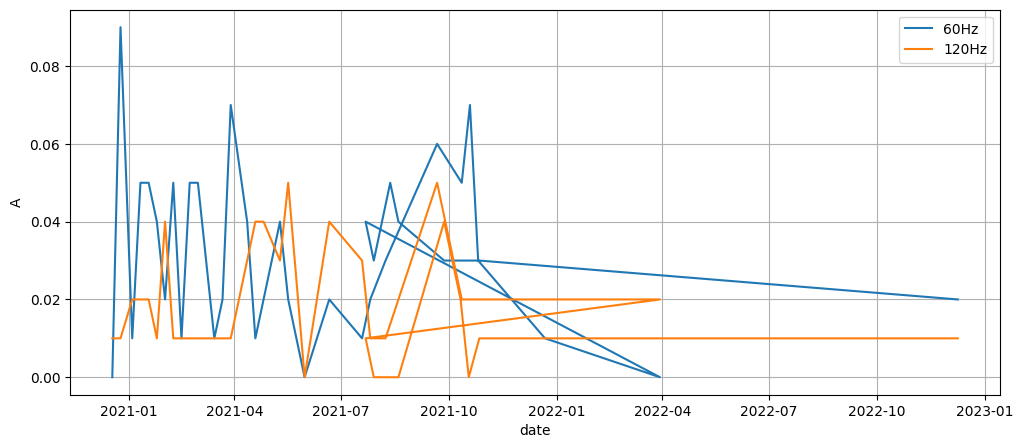

In [11]:
import matplotlib.pyplot as plt
df3[["60Hz", "120Hz"]].plot(figsize=(12, 5))

plt.ylabel("A")
plt.xlabel("date")
plt.grid(True)
plt.show()
